In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from moztelemetry.dataset import Dataset

%matplotlib inline

### Basics

We will use the Dataset API to fetch data.  Documentation can be found at: https://python-moztelemetry.readthedocs.io/en/stable/api.html#dataset

The goal of this example is to plot the startup distribution for each OS. Let's see how many parallel workers we have at our disposal:

In [2]:
sc.defaultParallelism

32

We can look at the schema of the dataset we are interested in:

In [3]:
Dataset.from_source('telemetry').schema

[u'submissionDate',
 u'sourceName',
 u'sourceVersion',
 u'docType',
 u'appName',
 u'appUpdateChannel',
 u'appVersion',
 u'appBuildId']

Let's create a Dataset of Telemetry submissions for a given submission date:

In [4]:
pings_dataset = (
    Dataset.from_source('telemetry')
    .where(docType='main')
    #.where(appBuildId='20180721100146')
    .where(submissionDate='20180806')
    .where(appUpdateChannel="nightly")
)

Select only the properties we need and then take a 10% sample:

In [5]:
pings = (
    pings_dataset
    .select(
        'clientId',
        buildId='application.buildId',
        content_paint='payload.processes.content.histograms.CONTENT_PAINT_TIME.values',
        tab_switch='payload.histograms.FX_TAB_SWITCH_TOTAL_E10S_MS.values',
        frame_time='payload.processes.gpu.histograms.CONTENT_FRAME_TIME.values',
        frame_time_sum='payload.processes.gpu.histograms.CONTENT_FRAME_TIME.sum',
        composite_time='payload.processes.gpu.histograms.COMPOSITE_TIME',
        checkerboardin='payload.processes.gpu.histograms.CHECKERBOARD_SEVERITY.values',
        experiments='environment.experiments',
        osName='environment.system.os.name',
        gfx='environment.system.gfx')
    .records(sc, sample=0.1)
)

This 'sampling' is based on s3 files and is highly
susceptible to skew. Use only for quicker performance
while prototyping.
fetching 679.34190MB in 2539 files...


In [6]:
#pings = (
#    pings_dataset
#    .records(sc, sample=0.01)
#)
#pings.take(1)

In [7]:
pings.count()

20266

In [8]:
pings.take(4)

[{'buildId': u'20180806100140',
  'checkerboardin': None,
  'clientId': u'55056b55-66a4-47bd-99ec-3a3faa6cd89a',
  'composite_time': {u'bucket_count': 50,
   u'histogram_type': 0,
   u'range': [1, 1000],
   u'sum': 11,
   u'values': {u'0': 31, u'11': 1, u'12': 0}},
  'content_paint': None,
  'experiments': {u'searchCohort': {u'branch': u'nov17-2'}},
  'frame_time': {u'25': 0, u'29': 1, u'34': 0},
  'frame_time_sum': 30,
  'gfx': {u'ContentBackend': u'Skia',
   u'D2DEnabled': True,
   u'DWriteEnabled': True,
   u'adapters': [{u'GPUActive': True,
     u'RAM': 2048,
     u'description': u'AMD Radeon R9 200 Series',
     u'deviceID': u'0x6810',
     u'driver': u'aticfx64 aticfx64 aticfx64 amdxc64 aticfx32 aticfx32 aticfx32 amdxc32 atiumd64 atidxx64 atidxx64 atiumdag atidxx32 atidxx32 atiumdva atiumd6a atitmm64',
     u'driverDate': u'1-31-2018',
     u'driverVersion': u'23.20.15017.3010',
     u'subsysID': u'04641043',
     u'vendorID': u'0x1002'}],
   u'features': {u'advancedLayers': {u's

In [9]:
# We add two extra steps. The first rewrites the ping to have some
# information more easily accessible (like the primary adapter),
# and the second step removes any pings that don't have adapter
# information.
def rewrite_ping(p):
    adapters = p.get('gfx', None).get('adapters', None)
    if not adapters:
        return None
    adapter = adapters[0]
            
    p['adapter'] = adapter
            
    # Convert the version to a tuple of integers.
    #if 'driverVersion' in adapter:
    #    p['driverVersion'] = [int(n) for n in adapter['driverVersion'].split('.') if n.isdigit()]
    return p

def filter_ping(p):
    return 'adapter' in p
rpings = pings.map(rewrite_ping).filter(filter_ping)
rpings = rpings.cache()
rpings.count()

20266

To prevent pseudoreplication, let's consider only a single submission for each client. As this step requires a distributed shuffle, it should always be run only after extracting the attributes of interest with *Dataset.select()*.

In [10]:
subset = (
    rpings
    .map(lambda p: (p['clientId'], p))
    .reduceByKey(lambda p1, p2: p1)
    .map(lambda p: p[1])
)

Caching is fundamental as it allows for an iterative, real-time development workflow:

In [11]:
cached = subset.cache()

How many pings are we looking at?

In [12]:
cached.count()

14493

In [13]:
cached.filter(lambda p: p['checkerboardin']).count()

5052

In [14]:
cached = cached.filter(lambda p: "features" in p["gfx"])
cached = cached.filter(lambda p: "wrQualified" in p["gfx"]["features"])
cached.count()

12481

In [15]:
wrQualified = cached.filter(lambda p: p["gfx"]["features"]["wrQualified"]["status"] == "available" )
wrQualified.count()
wrQualified = wrQualified.filter(lambda p: len(p["gfx"]["monitors"]) == 1 and p["gfx"]["monitors"][0]["refreshRate"] == 60)

In [16]:
wrExperiment = cached.filter(lambda p: "experiments" in p and p["experiments"]).filter(lambda p: "prefflip-webrender-v1-1-1474484" in p["experiments"])
wrExperiment.map(lambda p: p["gfx"]["features"]["compositor"]).countByValue()

defaultdict(int, {u'basic': 123, u'd3d11': 2622, u'webrender': 664})

In [31]:
wrExperiment = wrExperiment.filter(lambda p: p["gfx"]["features"]["wrQualified"]["status"] == "available")
wrExperiment = wrExperiment.filter(lambda p: len(p["gfx"]["monitors"]) == 1 and p["gfx"]["monitors"][0]["refreshRate"] == 60)

In [32]:
wrExperiment.map(lambda p: p["experiments"]["prefflip-webrender-v1-1-1474484"]["branch"]).countByValue()

defaultdict(int, {u'control': 495, u'treatment': 472})

In [33]:
treatment = wrExperiment.filter(lambda p: p["experiments"]["prefflip-webrender-v1-1-1474484"]["branch"] == "treatment")
control = wrExperiment.filter(lambda p: p["experiments"]["prefflip-webrender-v1-1-1474484"]["branch"] == "control")


In [34]:
wrt = qTreatment.filter(lambda p: p["gfx"]["features"]["compositor"] == 'd3d11').filter(lambda p: 'webrender' in p["gfx"]["features"])
wrt.map(lambda p: p["gfx"]["features"]["webrender"]["status"]).countByValue()
#wrt.count()

NameError: name 'qTreatment' is not defined

In [21]:
cached.filter(lambda p: p['checkerboardin']).map(lambda p: p["gfx"]["features"]["compositor"]).countByValue()

defaultdict(int,
            {u'basic': 196,
             u'd3d11': 4122,
             u'none': 1,
             u'opengl': 1,
             u'webrender': 341})

In [22]:
checked = cached.filter(lambda p: p['checkerboardin']).filter(lambda p: p["gfx"]["features"]["compositor"] == "webrender")
checked.map(lambda p: p["gfx"]["D2DEnabled"]).countByValue()

defaultdict(int, {None: 3, False: 2, True: 336})

In [35]:
treatment.map(lambda p: p["gfx"]["features"]["compositor"]).countByValue()

defaultdict(int, {u'basic': 8, u'd3d11': 193, u'webrender': 271})

In [24]:
wrQualified.take(1)

[{'adapter': {u'GPUActive': True,
   u'RAM': 2048,
   u'description': u'NVIDIA GeForce GTX 660',
   u'deviceID': u'0x11c0',
   u'driver': u'C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumdx.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumdx.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumdx.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumdx.dll C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumd.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumd.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumd.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumd.dll',
   u'driverDate': u'5-7-2018',
   u'driverVers

In [36]:
wrEnabled = treatment.filter(lambda p: p["gfx"]["features"]["compositor"] == "webrender")
wrDisabled = control.filter(lambda p: p["gfx"]["features"]["compositor"] == "d3d11")
wrEnabled.count(), wrDisabled.count()

(271, 476)

In [37]:
wrDisabled2 = wrDisabled.sample(False, wrEnabled.count()/(wrDisabled.count()*1.0))
wrDisabled3 = wrDisabled.sample(False, wrEnabled.count()/(wrDisabled.count()*1.0))
wrDisabled = wrDisabled.sample(False, wrEnabled.count()/(wrDisabled.count()*1.0))

In [38]:
wrDisabled3.count(), wrDisabled.count(), wrDisabled2.count(), wrEnabled.count()

(273, 280, 260, 271)

In [28]:
wrQualified.map(lambda p: p['buildId']).countByValue()

defaultdict(int,
            {u'20180721220720': 1,
             u'20180722100230': 5,
             u'20180722220044': 1,
             u'20180723100101': 3,
             u'20180723220051': 3,
             u'20180724100052': 2,
             u'20180724223402': 1,
             u'20180725103029': 6,
             u'20180726001822': 3,
             u'20180726100339': 3,
             u'20180726220124': 3,
             u'20180727103347': 4,
             u'20180727231224': 2,
             u'20180728101501': 2,
             u'20180728220145': 4,
             u'20180729100102': 2,
             u'20180729220222': 4,
             u'20180730100211': 6,
             u'20180730221422': 8,
             u'20180731105217': 5,
             u'20180731220208': 12,
             u'20180801100116': 8,
             u'20180801223951': 9,
             u'20180802100128': 15,
             u'20180802220056': 20,
             u'20180803104322': 16,
             u'20180803220259': 41,
             u'20180804124335': 4

In [50]:
normandy = treatment.filter(lambda p: p['buildId'] == '20180731105217')
treatment.map(lambda p: p["gfx"]["features"]["compositor"]).countByValue()
#normandy.count()
#normandy.map(lambda p: p["adapter"]["deviceID"]).countByValue()
#normandy.filter(lambda p: p["gfx"]["features"]["compositor"] == "webrender").take(4)


defaultdict(int, {u'basic': 64, u'd3d11': 1034, u'webrender': 637})

Let's group the startup timings by OS:

In [ ]:
grouped = (
    cached
    .map(lambda p: (p['osName'], p['firstPaint']))
    .groupByKey()
    .collectAsMap()
)

And finally plot the data:

In [ ]:
frame = pd.DataFrame({x: np.log10(pd.Series(list(y))) for x, y in grouped.items()})
plt.figure(figsize=(17, 7))
frame.boxplot(return_type='axes')
plt.ylabel('log10(firstPaint)')
plt.show()

In [ ]:
plt.title('startup distribution for Windows')
plt.ylabel('count')
plt.xlabel('log10(firstPaint)')
frame['Windows_NT'].plot(kind='hist', bins=50, figsize=(14, 7))

### Histograms

Let's extract a histogram of GC_MARK_MS (time spent running JS garbage collection mark phase) from the submissions:

(see https://developer.mozilla.org/en-US/docs/Web/JavaScript/Memory_Management for more information)

In [ ]:
histograms = (
    pings_dataset
    .select(GC_MARK_MS_content='payload.processes.content.histograms.GC_MARK_MS.values',
            GC_MARK_MS_parent='payload.histograms.GC_MARK_MS.values')
    .records(sc, sample=0.05)
)

- `payload.histograms.GC_MARK_MS.values` is a path to the GC_MARK_MS values of the parent (main) process
- `payload.processes.content.histograms.GC_MARK_MS.values` is a path to the GC_MARK_MS values of the child processes

Let's aggregate the histogram over all submissions and plot it as a histogram.  Since the parent and child processes are recorded separately, we can create a histogram for each one and then add them together.

Each histogram is a pandas series where the index is the bucket and the value is the count.

In [66]:
def aggregate_series(s1, s2):
    """Function to sum up series; if one is None, return other"""
    if s1 is None:
        return s2
    if s2 is None:
        return s1
    return s1.add(s2, fill_value=0)

In [26]:


aggregated_enabled = (
    wrEnabled
    .map(lambda p: pd.Series(p['content_paint']))
    .reduce(aggregate_series)
)
aggregated_enabled.index = [int(i) for i in aggregated_enabled.index]
aggregated_enabled = aggregated_enabled.sort_index()

aggregated_disabled = (
    wrDisabled2
    .map(lambda p: pd.Series(p['content_paint']))
    .reduce(aggregate_series)
)
aggregated_disabled.index = [int(i) for i in aggregated_disabled.index]
aggregated_disabled = aggregated_disabled.sort_index()

In [ ]:
aggregated_disabled.sum()

In [ ]:
aggregated_enabled.sum()

In [ ]:
aggregated_disabled.loc[0:7].sum()/aggregated_disabled.sum()

In [ ]:
aggregated_enabled.loc[0:7].sum()/aggregated_enabled.sum()

In [ ]:
aggregated_disabled.loc[16].sum()/aggregated_disabled.loc[16:].sum()


In [ ]:
aggregated_enabled.loc[16].sum()/aggregated_enabled.loc[16:].sum()


In [ ]:
aggregated_enabled[22:].sum()

In [ ]:
aggregated_disabled[22:].sum()

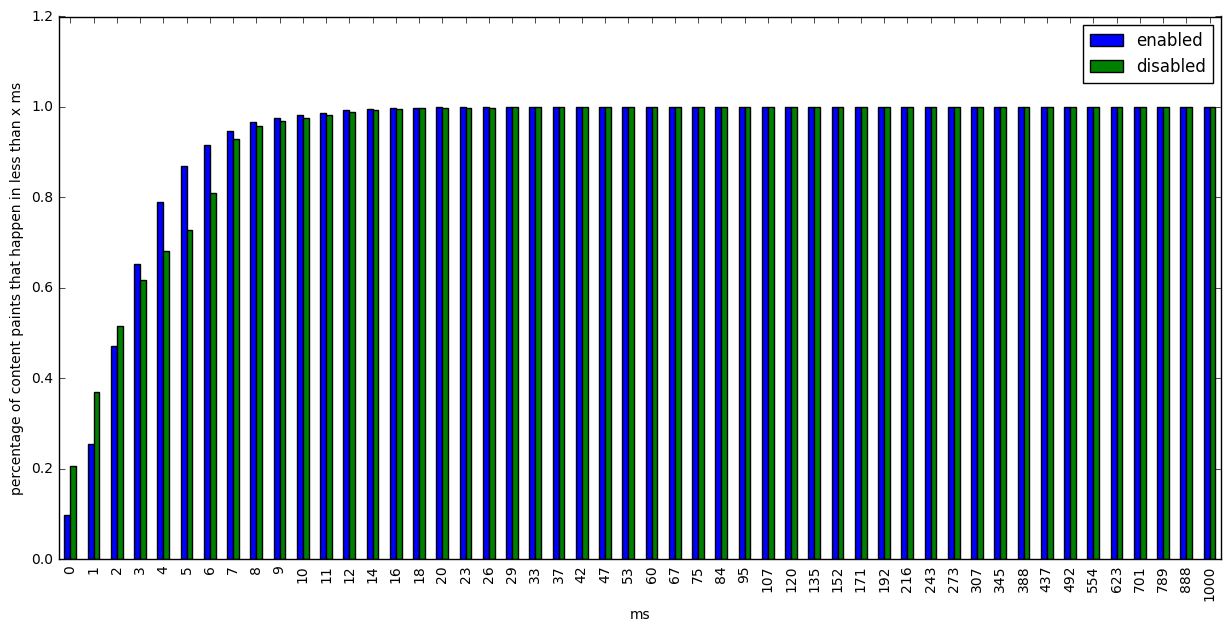

In [47]:
percent_enabled = aggregated_enabled[:].map(lambda x: x/aggregated_enabled[0:].sum())
percent_disabled = aggregated_disabled[:].map(lambda x: x/aggregated_disabled[0:].sum())

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
p = df.cumsum().plot(kind='bar', figsize=(15, 7))
p.set_xlabel("ms")
p.set_ylabel("percentage of content paints that happen in less than x ms")


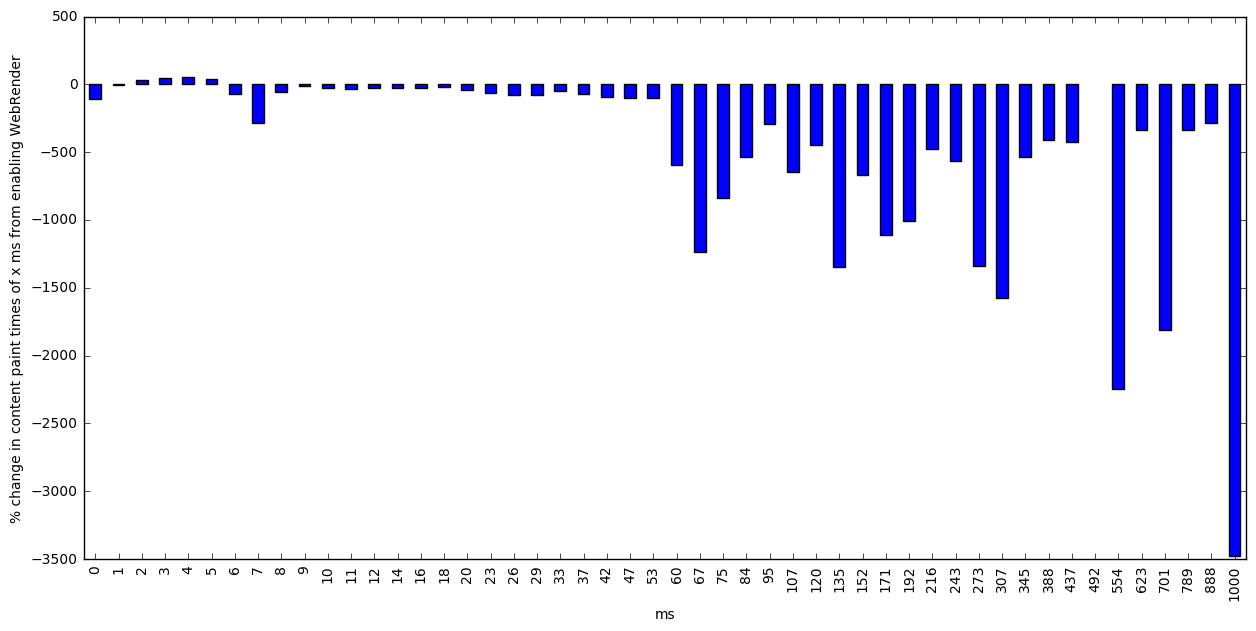

In [49]:
p = (100*(percent_enabled - percent_disabled) / percent_enabled).plot(kind='bar', figsize=(15, 7))
p.set_xlabel("ms")
p.set_ylabel("% change in content paint times of x ms from enabling WebRender")

In [30]:
tab_aggregated_enabled = (
    wrEnabled
    .map(lambda p: pd.Series(p['tab_switch']))
    .reduce(aggregate_series)
)
tab_aggregated_enabled.index = [int(i) for i in tab_aggregated_enabled.index]
tab_aggregated_enabled = tab_aggregated_enabled.sort_index()

tab_aggregated_disabled = (
    wrDisabled2
    .map(lambda p: pd.Series(p['tab_switch']))
    .reduce(aggregate_series)
)
tab_aggregated_disabled.index = [int(i) for i in tab_aggregated_disabled.index]
tab_aggregated_disabled = tab_aggregated_disabled.sort_index()

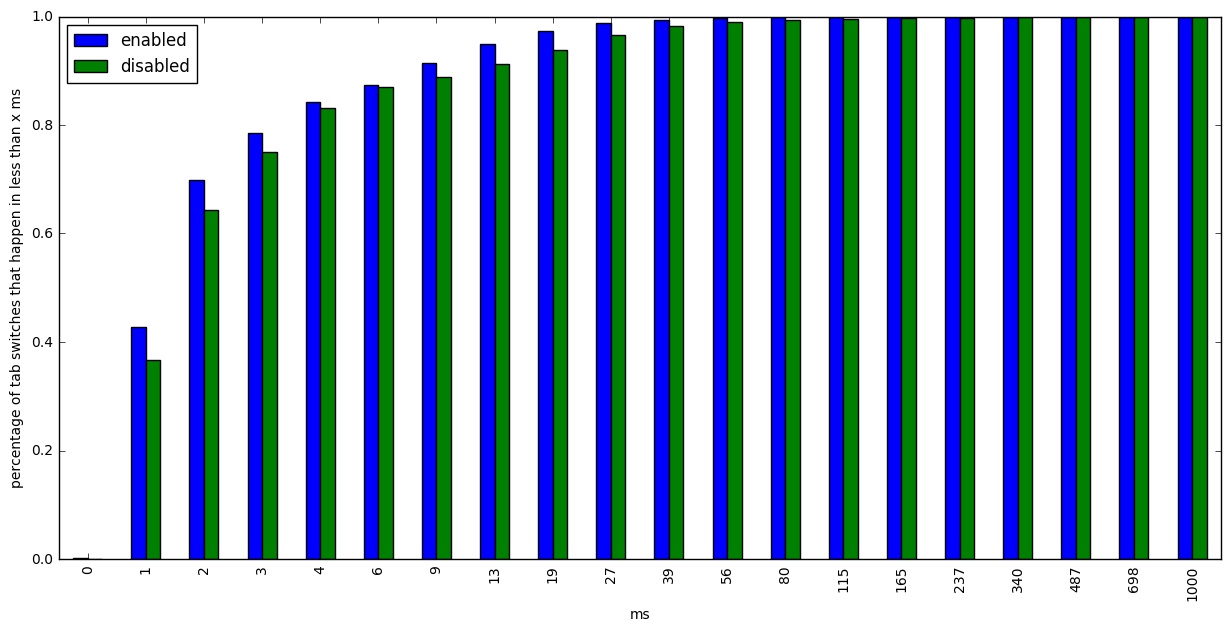

In [45]:
percent_enabled = tab_aggregated_enabled[0:].map(lambda x: x/tab_aggregated_enabled[0:].sum())
percent_disabled = tab_aggregated_disabled[0:].map(lambda x: x/tab_aggregated_disabled[0:].sum())

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
p = df.cumsum().plot(kind='bar', figsize=(15, 7))
p.set_ylabel("percentage of tab switches that happen in less than x ms")
p.set_xlabel("ms")
#df

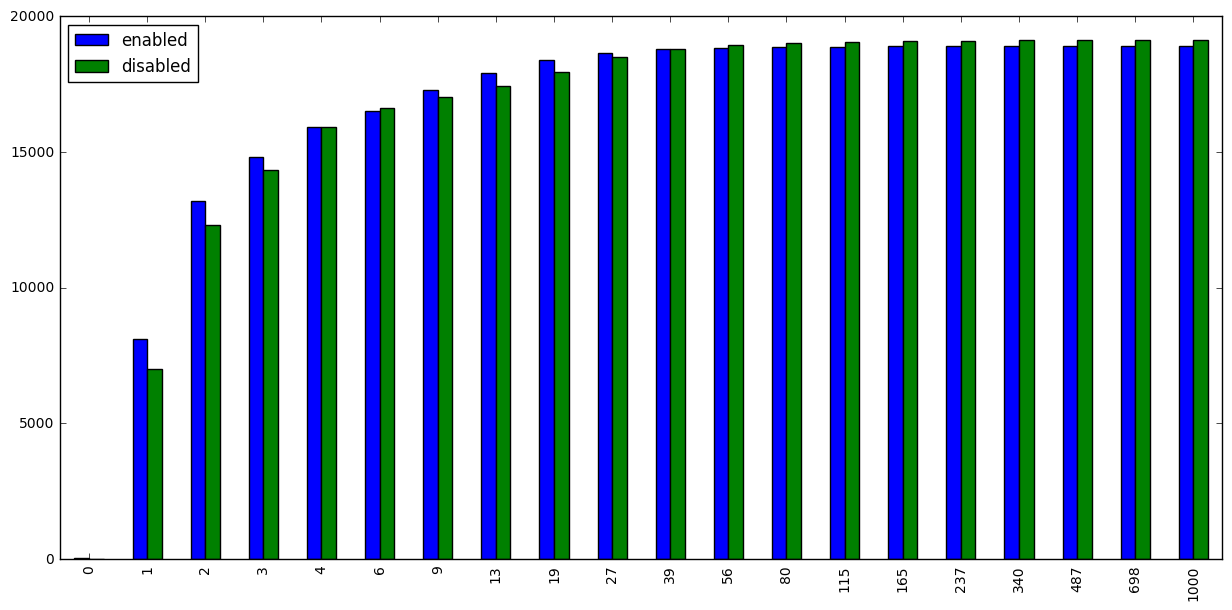

In [34]:
percent_enabled = tab_aggregated_enabled[0:]
percent_disabled = tab_aggregated_disabled[0:]

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
df.cumsum().plot(kind='bar', figsize=(15, 7))
#df

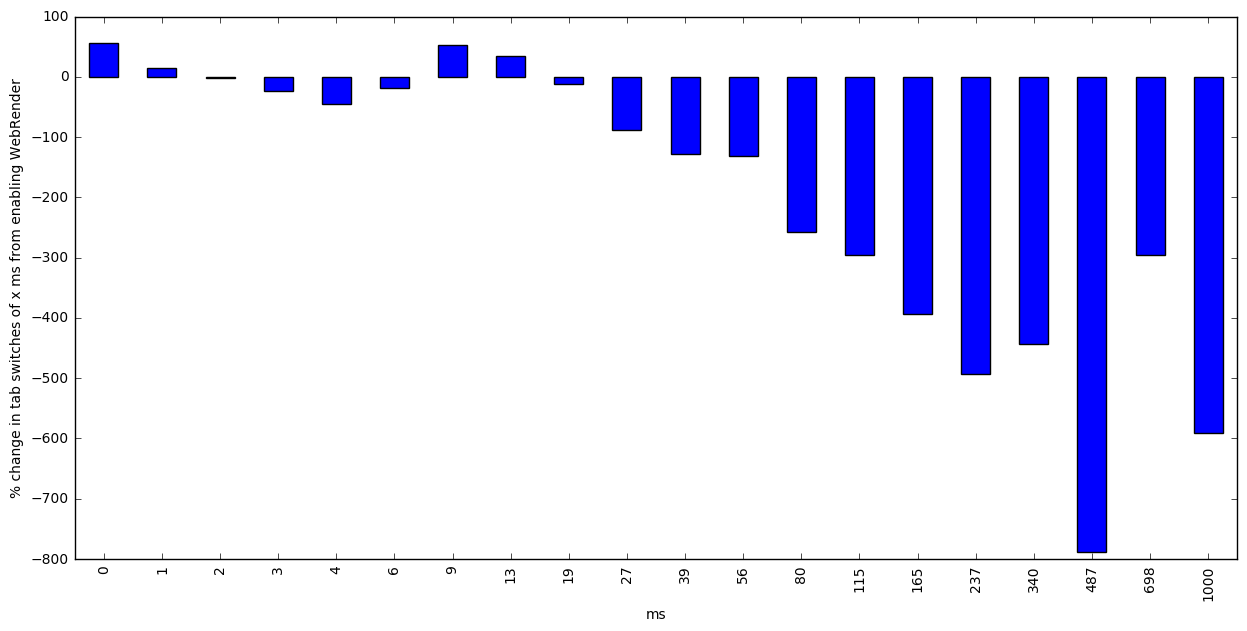

In [46]:
p = (100*(percent_enabled - percent_disabled) / percent_enabled).plot(kind='bar', figsize=(15, 7))
p.set_xlabel("ms")
p.set_ylabel("% change in tab switches of x ms from enabling WebRender")

In [ ]:
plt.title('wr_enabled')
precent_enabled.plot(kind='bar', figsize=(15, 7))

In [ ]:
plt.title('wr_disabled')
aggregated_disabled.plot(kind='bar', figsize=(15, 7))
aggregated_enabledd.plot(kind='bar', figs)

In [183]:
check_aggregated_enabled = (
    wrEnabled
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_enabled.index = [int(i) for i in check_aggregated_enabled.index]
check_aggregated_enabled = check_aggregated_enabled.sort_index()

check_aggregated_disabled = (
    wrDisabled
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_disabled.index = [int(i) for i in check_aggregated_disabled.index]
check_aggregated_disabled = check_aggregated_disabled.sort_index()

check_aggregated_disabled2 = (
    wrDisabled2
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_disabled2.index = [int(i) for i in check_aggregated_disabled2.index]
check_aggregated_disabled2 = check_aggregated_disabled2.sort_index()

check_aggregated_disabled3 = (
    wrDisabled3
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_disabled3.index = [int(i) for i in check_aggregated_disabled3.index]
check_aggregated_disabled3 = check_aggregated_disabled3.sort_index()

,enabled,disabled,disabled2,disabled3
0,90.0,102.0,159.0,108.0
1,4.0,3.0,2.0,3.0
2,11.0,10.0,3.0,4.0
3,1.0,10.0,13.0,3.0
5,10.0,12.0,12.0,9.0
8,8.0,23.0,14.0,4.0
12,48.0,75.0,61.0,51.0
18,65.0,240.0,243.0,228.0
28,38.0,97.0,91.0,90.0
43,27.0,57.0,49.0,22.0


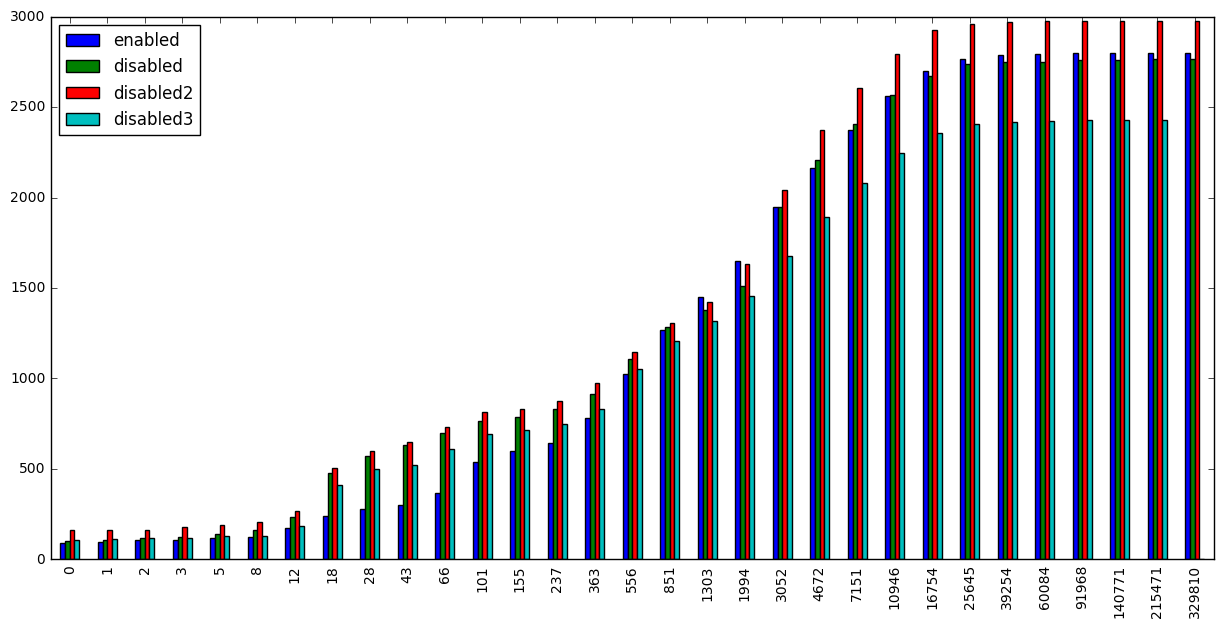

In [184]:
df = pd.DataFrame()
df['enabled'] = check_aggregated_enabled
df['disabled'] = check_aggregated_disabled
df['disabled2'] = check_aggregated_disabled2
df['disabled3'] = check_aggregated_disabled3

#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
df.cumsum().plot(kind='bar', figsize=(15, 7))
df

#df

In [117]:
def add_pair(x, y):
  if x[0] is None and y[0] is None:
    return (None, x[1]+y[1])
  return (x[0]+y[0], x[1]+y[1])

preserve = ["client_id", "branch", "compositor", "wrQualified", "wrStatus"]

def explode_user_agg(x):
  """Explodes our selected histograms from each ping into key-value pairs like
  [(client_id, probe_name), (sum_values, n_values)].
  
  For distributions, sum and n are meaningful. For counts, sum_values is 0 or None.
  """
  def key_for_label(label):
    return tuple([x[i] for i in preserve] + [label])
  
  rows = []
  for label, procs, method in histograms:
    key = key_for_label(label)
    value = (0, 0)
    for proc in procs:
      v_sum = x["{}/{}/{}".format(label, proc, "sum")] or 0
      # count the number of recorded events
      v_values = sum((x["{}/{}/{}".format(label, proc, "values")] or {0: 0}).values())
      value = add_pair(value, (v_sum, v_values))
    rows.append([key, value])
  
  for label, procs, method in keyedHistograms:
    key = key_for_label(label)
    for proc in procs:
      probe = x["{}/{}".format(label, proc)]
      if not probe:
        continue
      first_key = list(probe.values())[0]
      n_events = sum(first_key["values"].values())
      rows.append([key, (None, n_events)])

  return rows

def deaggregate(x):
  fields = {k: v for k, v in zip(preserve + ["probe"], x[0])}
  fields["sum_values"], fields["n_values"] = x[1]
  return Row(**fields)

per_user_key = (
  wrDisabled
  .flatMap(explode_user_agg)
  .reduceByKey(add_pair)
  .map(deaggregate)
)
per_user_key.take(1)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 15 in stage 257.0 failed 4 times, most recent failure: Lost task 15.3 in stage 257.0 (TID 3764, ip-172-31-3-114.us-west-2.compute.internal, executor 2): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/worker.py", line 177, in main
    process()
  File "/usr/lib/spark/python/pyspark/worker.py", line 172, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2423, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2423, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 346, in func
    return f(iterator)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 1842, in combineLocally
    merger.mergeValues(iterator)
  File "/usr/lib/spark/python/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<ipython-input-117-6b9aeb4be8a3>", line 18, in explode_user_agg
NameError: global name 'histograms' is not defined

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:404)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:338)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1708)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1696)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1695)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1695)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:855)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:855)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:855)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1867)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:671)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2029)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2050)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2069)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:455)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor82.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/worker.py", line 177, in main
    process()
  File "/usr/lib/spark/python/pyspark/worker.py", line 172, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2423, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2423, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 346, in func
    return f(iterator)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 1842, in combineLocally
    merger.mergeValues(iterator)
  File "/usr/lib/spark/python/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<ipython-input-117-6b9aeb4be8a3>", line 18, in explode_user_agg
NameError: global name 'histograms' is not defined

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:404)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:338)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [115]:
wrDisabled.filter(lambda p: p['frame_time']).take(1)

[{'adapter': {u'GPUActive': True,
   u'RAM': 2048,
   u'description': u'NVIDIA GeForce GTX 660',
   u'deviceID': u'0x11c0',
   u'driver': u'C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumdx.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumdx.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumdx.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumdx.dll C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumd.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumd.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumd.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumd.dll',
   u'driverDate': u'5-7-2018',
   u'driverVers

In [ ]:
int(5) < 100

In [48]:
from collections import Counter

In [58]:
def roundDict(x):
    d = {}
    for (key, value) in x.iteritems():
        if int(key) < 100:
            continue
        rounded = int(key)/100
        if rounded in d:
            d[rounded] += value
        else:
            d[rounded] = value
    return d
def sumHist(x):
    s = 0
    for (key, value) in x.iteritems():
        s += key * value
    return s
def countHist(x):
    s = 0
    for (key, value) in x.iteritems():
        s += value
    return s

In [62]:
wrEnabled.filter(lambda p: p['frame_time']).map(lambda p: roundDict(p['frame_time'])).filter(lambda p: countHist(p) != 0).map(lambda p: sumHist(p)/countHist(p)).take(200)

[5,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 9,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 16,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 16,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1]

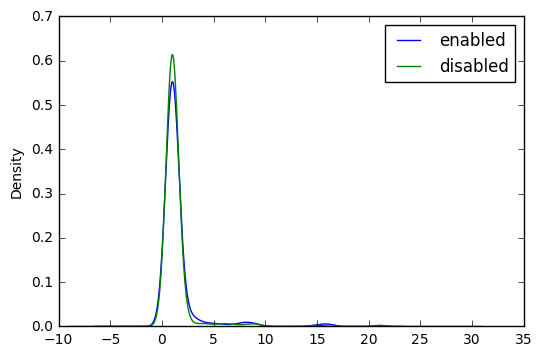

In [63]:
#means = (
#    wrEnabled.filter(lambda p: p['frame_time']).map(lambda p: p['frame_time_sum']/sum(p['frame_time'].values()))
#    .filter(lambda p: p< 1000)
#)
means = (wrEnabled.filter(lambda p: p['frame_time']).map(lambda p: roundDict(p['frame_time']))
         .filter(lambda p: countHist(p) != 0)
         .map(lambda p: sumHist(p)/countHist(p))
        )
means = means.map(lambda x: (x, )).toDF()
means = means.toPandas()
df = pd.DataFrame()
df['enabled'] = means
means = (wrDisabled.filter(lambda p: p['frame_time']).map(lambda p: roundDict(p['frame_time']))
         .filter(lambda p: countHist(p) != 0)
         .map(lambda p: sumHist(p)/countHist(p))
        )
means = means.map(lambda x: (x, )).toDF()
means = means.toPandas()
df['disabled'] = means
df.plot.density()#means.take(4)

In [47]:
means = (
    wrDisabled.filter(lambda p: p['composite_time']).map(lambda p: p['composite_time']['sum']/sum(p['composite_time']['values'].values()))
    .filter(lambda p: p< 1000)
)
means = means.map(lambda x: (x, )).toDF()
means = means.toPandas()
means

,_1
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


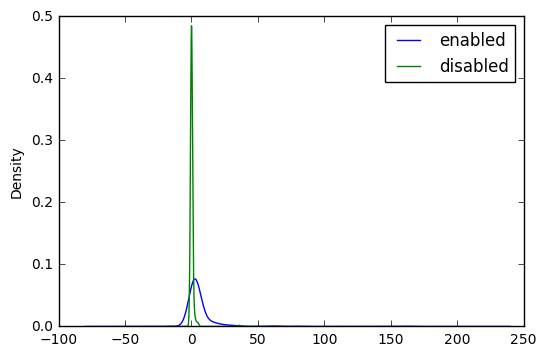

In [48]:
means = (
    wrEnabled.filter(lambda p: p['composite_time']).map(lambda p: p['composite_time']['sum']/sum(p['composite_time']['values'].values()))
    .filter(lambda p: p< 1000)
)
means = means.map(lambda x: (x, )).toDF()
means = means.toPandas()
df = pd.DataFrame()
df['enabled'] = means
means = (
    wrDisabled.filter(lambda p: p['composite_time']).map(lambda p: p['composite_time']['sum']/sum(p['composite_time']['values'].values()))
    .filter(lambda p: p< 1000)
)
means = means.map(lambda x: (x, )).toDF()
means = means.toPandas()
df['disabled'] = means
df.plot.density()#means.take(4)

In [61]:
aggregated_enabled = (
    wrEnabled
    .filter(lambda p: p['composite_time'])
    .map(lambda p: pd.Series(p['composite_time']['values']))
    .reduce(aggregate_series)
)
aggregated_enabled.index = [int(i) for i in aggregated_enabled.index]
aggregated_enabled = aggregated_enabled.sort_index()

aggregated_disabled = (
    wrDisabled2
    .filter(lambda p: p['composite_time'])
    .map(lambda p: pd.Series(p['composite_time']['values']))
    .reduce(aggregate_series)
)
aggregated_disabled.index = [int(i) for i in aggregated_disabled.index]
aggregated_disabled = aggregated_disabled.sort_index()

(59394031.0, 87039907.0, 284, 271)

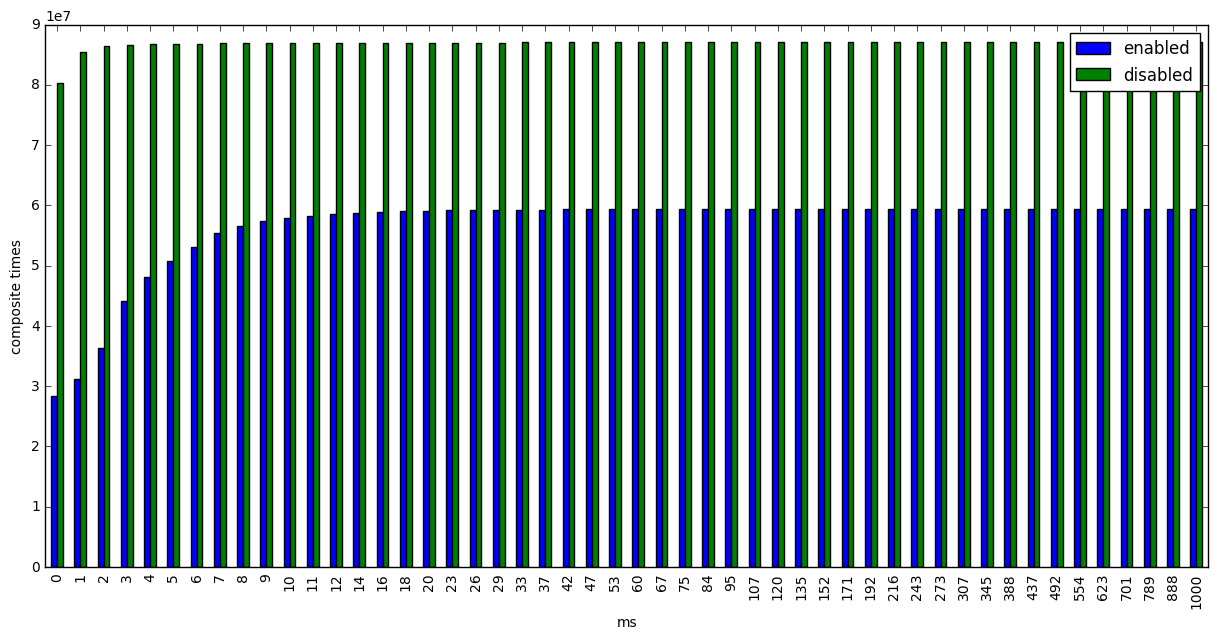

In [62]:
percent_enabled = aggregated_enabled
percent_disabled = aggregated_disabled

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
p = df.cumsum().plot(kind='bar', figsize=(15, 7))
p.set_xlabel("ms")
p.set_ylabel("composite times")
(aggregated_enabled.sum(), aggregated_disabled.sum(), wrEnabled.count(), wrDisabled.count())

In [70]:
aggregated_enabled = (
    wrEnabled
    .filter(lambda p: p['frame_time'])
    .map(lambda p: pd.Series(roundDict(p['frame_time'])))
    .reduce(aggregate_series)
)
aggregated_enabled.index = [int(i) for i in aggregated_enabled.index]
aggregated_enabled = aggregated_enabled.sort_index()

aggregated_disabled = (
    wrDisabled2
    .filter(lambda p: p['frame_time'])
    .map(lambda p: pd.Series(roundDict(p['frame_time'])))
    .reduce(aggregate_series)
)
aggregated_disabled.index = [int(i) for i in aggregated_disabled.index]
aggregated_disabled = aggregated_disabled.sort_index()

In [71]:
aggregated_disabled

1     3514425.0
2       25249.0
3       15626.0
4        5743.0
5        1518.0
6        1014.0
7         721.0
9         478.0
10        363.0
12        263.0
14        197.0
16        155.0
19        118.0
23        107.0
26         76.0
31         71.0
36         34.0
42         26.0
50        101.0
dtype: float64

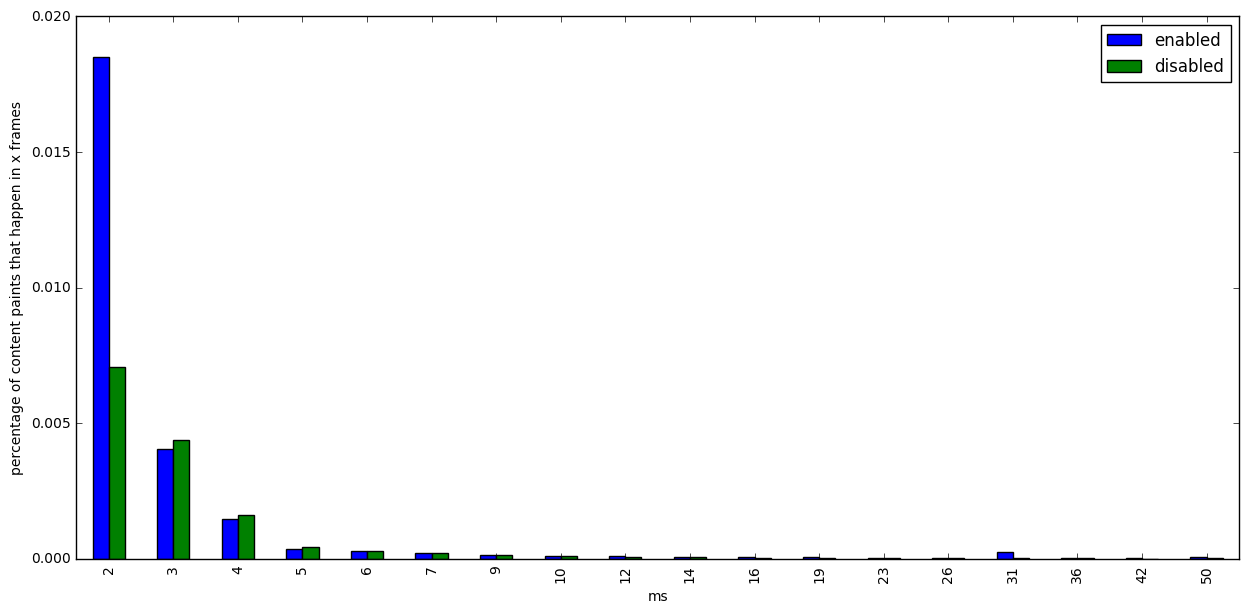

In [87]:
percent_enabled = aggregated_enabled[1:].map(lambda x: x/aggregated_enabled[0:].sum())
percent_disabled = aggregated_disabled[1:].map(lambda x: x/aggregated_disabled[0:].sum())

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
p = df.plot(kind='bar', figsize=(15, 7))
p.set_xlabel("ms")
p.set_ylabel("percentage of content paints that happen in x frames")

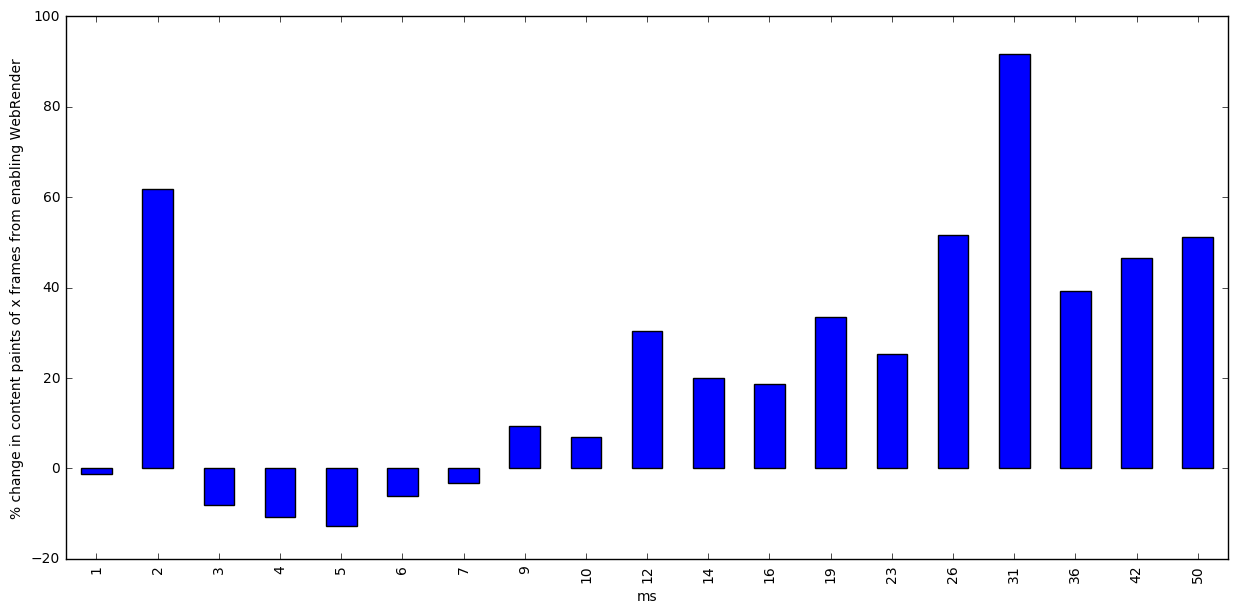

In [84]:
p = (100*(percent_enabled - percent_disabled) / percent_enabled).plot(kind='bar', figsize=(15, 7))
p.set_xlabel("ms")
p.set_ylabel("% change in content paints of x frames from enabling WebRender")

We can also aggregate the values of the parent and children processes:

In [ ]:
plt.title('GC_MARK_MS')
(aggregated_content + aggregated_parent).plot(kind='bar', figsize=(15, 7))

Keyed histograms follow a similar pattern. To extract a keyed histogram for which we know the key/label we are interested in:

In [ ]:
keyed_hist = (
    pings_dataset
    .select(redirects='payload.keyedHistograms.NETWORK_HTTP_REDIRECT_TO_SCHEME.https.values')
    .records(sc, sample=0.05)
)

Add up the counts of every ping and plot it:

In [ ]:
aggregated = (
    keyed_hist
    .filter(lambda p: p['redirects'] is not None)
    .map(lambda p: pd.Series(p['redirects']))
    .reduce(lambda c1, c2: c1 + c2)
)

In [ ]:
aggregated.plot(kind='bar', figsize=(15, 7))